# Dataset loading

You can download the dataset:
* Manually from the kaggle page via the link https://www.kaggle.com/datasets/ucffool/dice-d4-d6-d8-d10-d12-d20-images
* With using opendatasets and your own kaggle API key



## Downloading the data via opendatasates package

In [4]:
%pip install opendatasets

In [5]:
import pathlib
import json

# YOUR PATH HERE
DRIVE = pathlib.Path('/content/drive/MyDrive/Dice Recognition Project ')
API_key = DRIVE / 'kaggle.json'

In [ ]:
with open(API_key) as f:
    file = json.load(f)
    print(f'username: {file["username"]}, key:{file["key"]}')

In [7]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/ucffool/dice-d4-d6-d8-d10-d12-d20-images')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: strangerone
Your Kaggle Key: ··········


100%|██████████| 676M/676M [00:34<00:00, 20.4MB/s]


# All the necessary imports and constants

In [8]:
# Install the torchinfo and torchmetrics packages

%pip install torchinfo torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 9.6 MB/s eta 0:00:00


In [9]:
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import torchinfo
from torchmetrics import Accuracy

# YOUR PATH HERE
IMAGE_PATH = pathlib.Path('/content/dice-d4-d6-d8-d10-d12-d20-images/dice')
# make the system the device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device is {device}')


Using device is cuda


# Data visualization

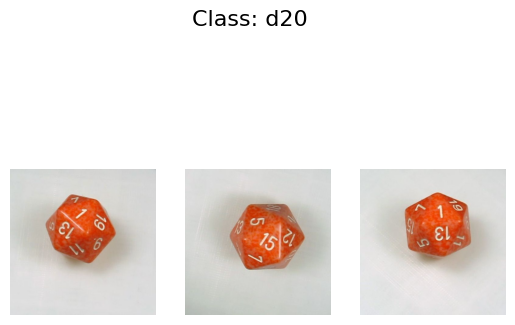

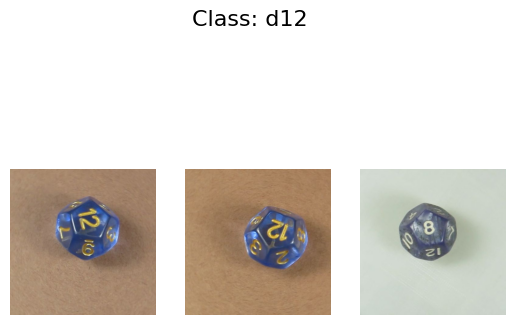

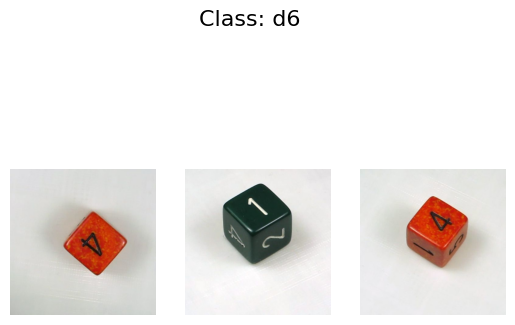

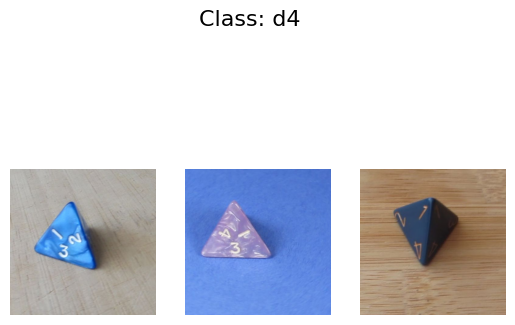

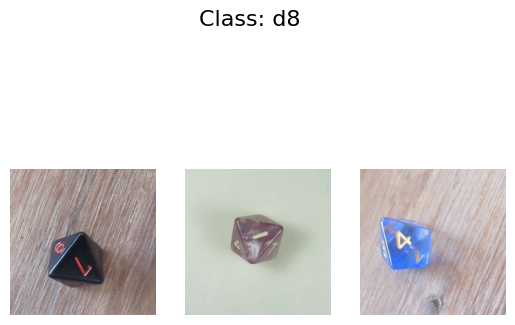

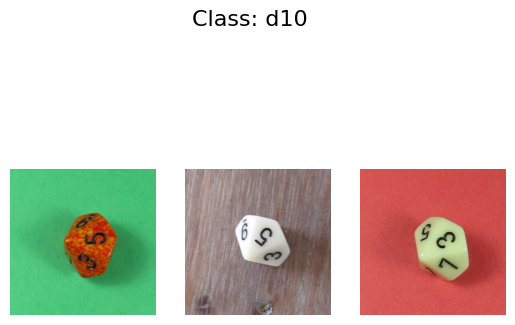

In [10]:
def plot_images(
    image_paths: pathlib.PosixPath,
    n:int = 3,
):
    '''Plot n random samples from each class'''

    for image_path in image_paths:
        images = list(pathlib.Path(image_path).glob('*.jpg'))
        random_image_paths = random.sample(images, k=3)
        fig, ax = plt.subplots(1, n)
        for i, image in enumerate(random_image_paths):
            with Image.open(image) as f:
                ax[i].imshow(f)
                ax[i].axis("off")
                fig.suptitle(f"Class: {image_path.stem}", fontsize=16)

image_path_list=list(IMAGE_PATH.glob('train/*/'))
plot_images(image_path_list, n=3)


# Dataset and model preparation

In the current task we're going to use the ResNet50 pretrained model.

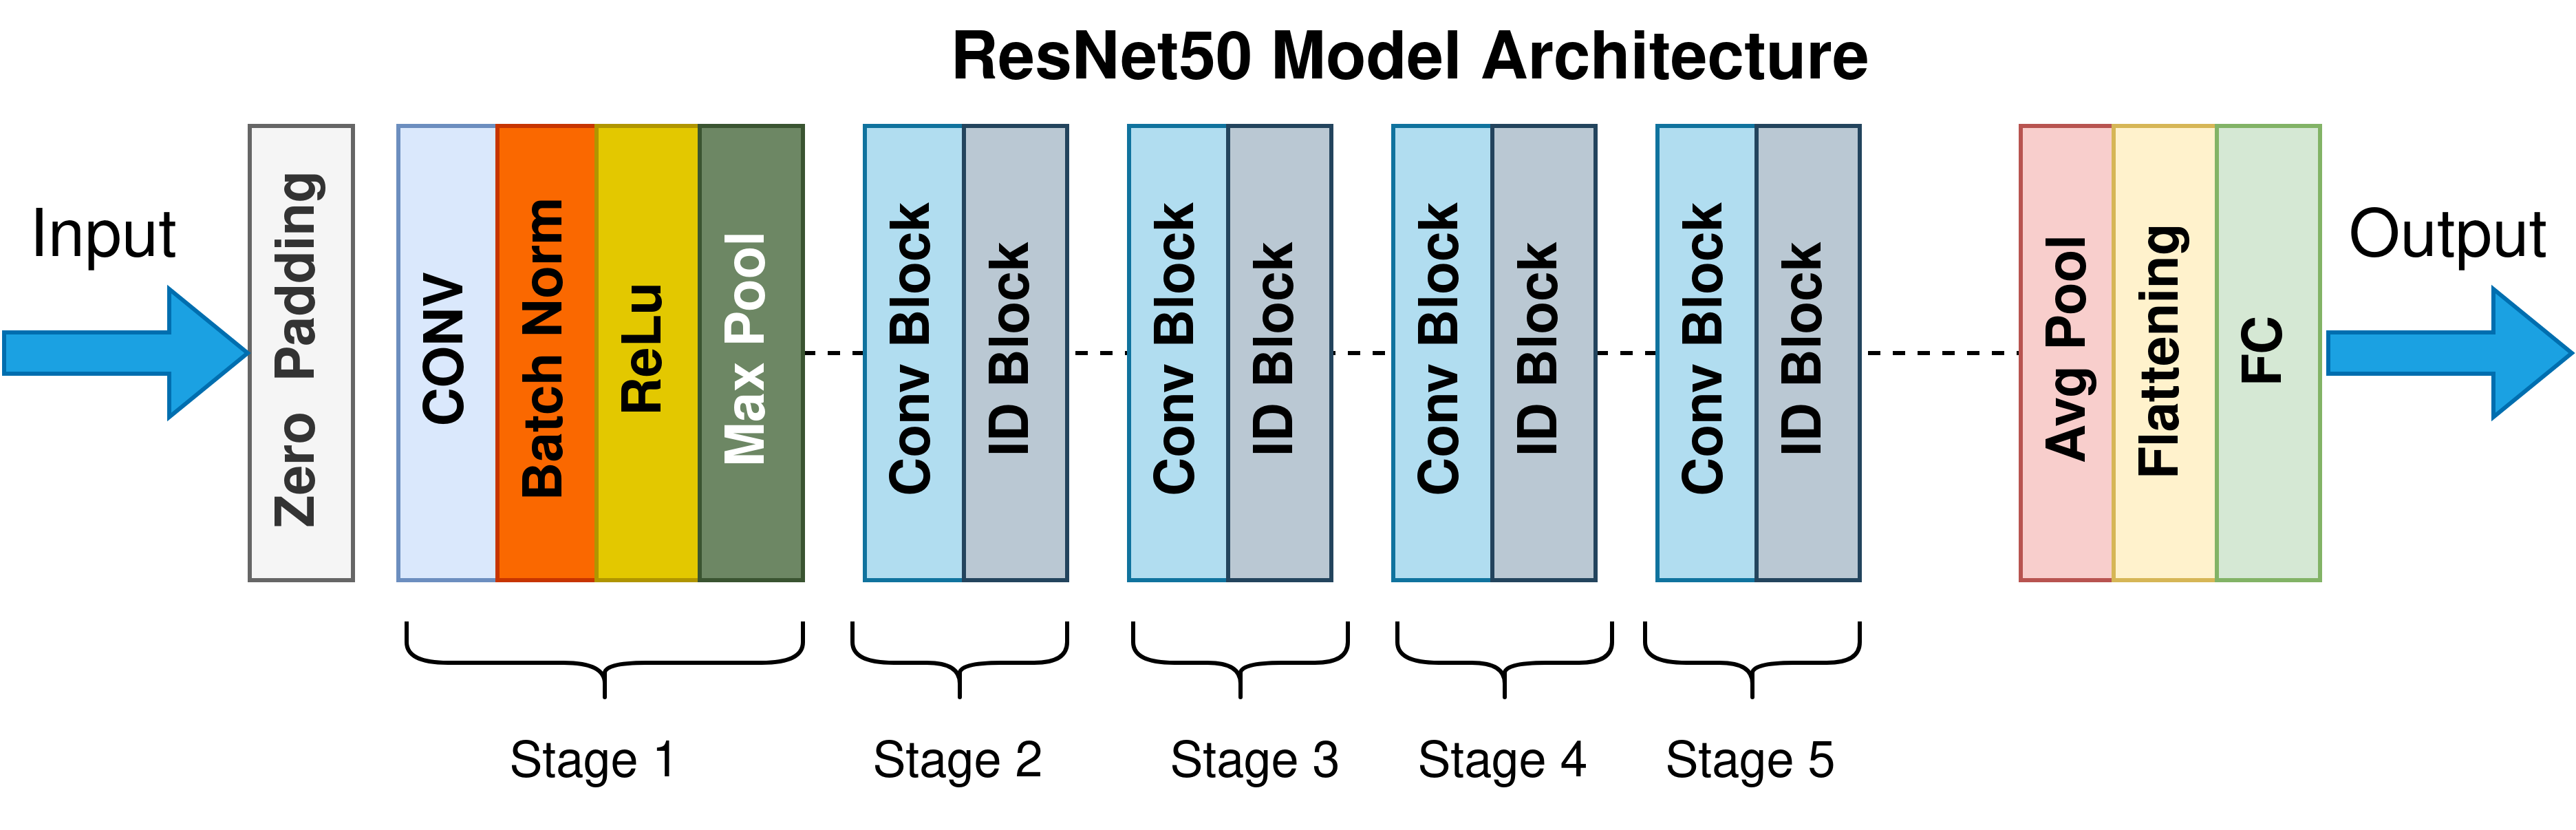

The link to the original paper: https://arxiv.org/pdf/1512.03385.pdf

## Transfer learning preparations

In [11]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)
print('The model has succesfully imported')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


The model has succesfully imported


In [12]:
# Check the architecture of the model to change the output layer characteristics

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [13]:
# Implement auto-transformation without data augmentation
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
train_dataset = datasets.ImageFolder(
    root=IMAGE_PATH / 'train',
    transform=auto_transforms,
    target_transform=None
)
test_dataset = datasets.ImageFolder(
    root=IMAGE_PATH / 'valid',
    transform=auto_transforms,
)

In [15]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [16]:
# Check the forward pass with using the transformed data

torchinfo.summary(model, input_size=next(iter(train_dataloader))[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [18]:
# Freeze layer's parameters
for param in model.parameters():
    param.requires_grad = False

# Reassign the output FC layer parpameters.
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 6)).to(device)

## Loss and accuracy fuctions. Scheduler and optimizer

In [19]:
# Define the optimizer, the loss and the accuracy fuctions
# In the current example the scheduler doesn't used, but it's up to you whether to implement it or not

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
acc_fn = Accuracy(task="multiclass", num_classes=6).to(device)

# uncomment if necessary and update the train/test functions
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer=optimizer,
#     mode='min',
#     verbose=True
# )

## Define Train and Test step functions

In [26]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    acc_fn=acc_fn
    ):

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        y_logits = model(X)

        pred_label = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        loss = loss_fn(y_logits, y)
        acc = acc_fn(pred_label, y)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    acc_fn=acc_fn
    ):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            pred_label = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

            loss = loss_fn(y_logits, y)
            acc = acc_fn(pred_label, y)

            test_loss += loss.item()
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc

In [31]:
from tqdm import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5
):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs), colour='red', desc='Training' ):
        print('\nThe training step is performing')
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            )
        print('The validation step is performing\n')
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn
            )

        print(
            f"\nEpoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [32]:
model_results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10)

Training:   0%|          | 0/10 [00:00<?, ?it/s]


The training step is performing
The validation step is performing



Training:  10%|█         | 1/10 [02:32<22:56, 152.96s/it]


Epoch: 1 | train_loss: 0.0509 | train_acc: 0.9849 | test_loss: 0.0998 | test_acc: 0.9811

The training step is performing
The validation step is performing



Training:  20%|██        | 2/10 [04:46<18:53, 141.73s/it]


Epoch: 2 | train_loss: 0.0443 | train_acc: 0.9886 | test_loss: 0.1089 | test_acc: 0.9806

The training step is performing
The validation step is performing



Training:  30%|███       | 3/10 [07:06<16:26, 140.89s/it]


Epoch: 3 | train_loss: 0.0510 | train_acc: 0.9879 | test_loss: 0.1461 | test_acc: 0.9796

The training step is performing
The validation step is performing



Training:  40%|████      | 4/10 [09:21<13:50, 138.39s/it]


Epoch: 4 | train_loss: 0.0290 | train_acc: 0.9926 | test_loss: 0.0804 | test_acc: 0.9891

The training step is performing
The validation step is performing



Training:  50%|█████     | 5/10 [11:37<11:27, 137.47s/it]


Epoch: 5 | train_loss: 0.0251 | train_acc: 0.9950 | test_loss: 0.2002 | test_acc: 0.9801

The training step is performing
The validation step is performing



Training:  60%|██████    | 6/10 [13:51<09:05, 136.42s/it]


Epoch: 6 | train_loss: 0.0287 | train_acc: 0.9935 | test_loss: 0.2123 | test_acc: 0.9825

The training step is performing
The validation step is performing



Training:  70%|███████   | 7/10 [16:06<06:47, 135.91s/it]


Epoch: 7 | train_loss: 0.0256 | train_acc: 0.9948 | test_loss: 0.2576 | test_acc: 0.9839

The training step is performing
The validation step is performing



Training:  80%|████████  | 8/10 [18:19<04:30, 135.18s/it]


Epoch: 8 | train_loss: 0.0201 | train_acc: 0.9957 | test_loss: 0.2066 | test_acc: 0.9830

The training step is performing
The validation step is performing



Training:  90%|█████████ | 9/10 [20:33<02:14, 134.77s/it]


Epoch: 9 | train_loss: 0.0176 | train_acc: 0.9963 | test_loss: 0.3508 | test_acc: 0.9825

The training step is performing
The validation step is performing



Training: 100%|██████████| 10/10 [22:47<00:00, 136.77s/it]


Epoch: 10 | train_loss: 0.0267 | train_acc: 0.9959 | test_loss: 0.3068 | test_acc: 0.9815


# Model evaluation

## Printing the training results

In [33]:
def plot_loss_acc_curves(results: dict[str, list[float]]):

    train_loss = results['train_loss']
    test_loss = results['test_loss']
    train_accuracy = [acc.to('cpu') for acc in results['train_acc']]
    test_accuracy = [acc.to('cpu') for acc in results['test_acc']]

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

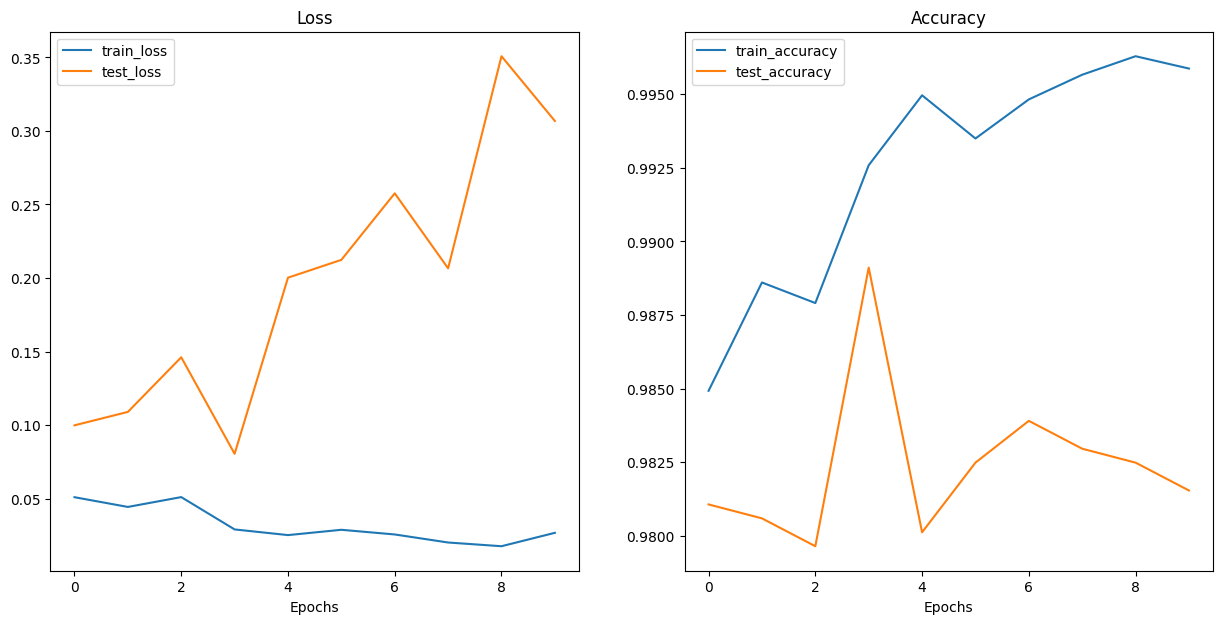

In [35]:
plot_loss_acc_curves(model_results)

Well... The model looks kinda overfitted, doesn't it? Probably, we shouldn't have used those so much epochs to train or should have used the lower learning rate or fit other hyperparameters better. Because the performance of the model is rather good we won't do nothing.

## Model evaluating visualization

In [36]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: pathlib.PosixPath,
    class_names: list[str] = None,
    transform=None,
    device: torch.device = device
    ):

    target_image = torchvision.io.read_image(str(image_path[0])).type(torch.float32)
    target_image = target_image / 255.

    if transform:
        original_image = target_image
        target_image = transform(target_image)

    model.to(device)
    model.eval()
    with torch.inference_mode():

        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(original_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


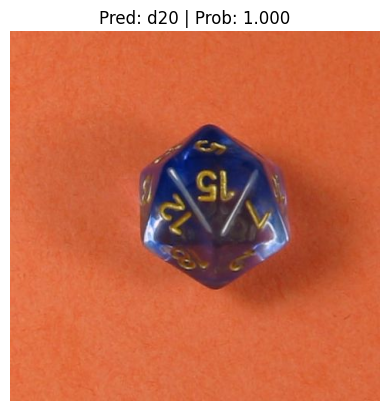

In [42]:
valid_set_path = pathlib.Path('/content/dice-d4-d6-d8-d10-d12-d20-images/dice-d4-d6-d8-d10-d12-d20/dice/valid')


custom_image_path = random.sample(list(valid_set_path.glob('*/*.jpg')),k=1)
class_names = train_dataset.classes

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=auto_transforms,
                    device=device)

## Confusion matrix

In [38]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    %pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [39]:
# Confusion matrix

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Predict'):
        X, y = X.to(device), y.to(device)

        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        preds.append(y_pred.cpu())
preds = torch.cat(preds)

Predict: 100%|██████████| 66/66 [00:24<00:00,  2.66it/s]


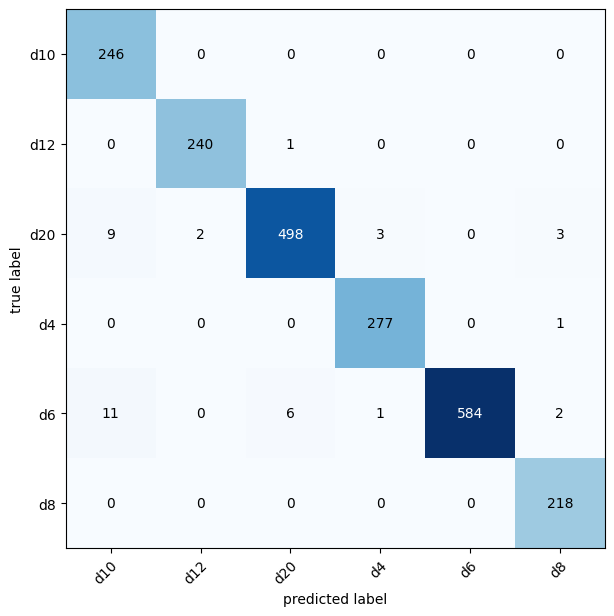

In [40]:
confmat = ConfusionMatrix(task="multiclass", num_classes=6)
confmat_tensor = confmat(preds, torch.as_tensor(test_dataset.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Model parameters saving

In [43]:
MODEL_PATH = pathlib.Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'DiceRecognitionResNet50Torch.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model parameters to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model parameters to: models/DiceRecognitionResNet50Torch.pth
